In [4]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchaudio.functional import lowpass_biquad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
SAMPLE_RATE = 16000
AUDIO_LEN = 16000
BATCH_SIZE = 16
LR = 1e-3
MESSAGE_BITS = 16
EPOCHS = 10
NUM_WORKERS = 8

LAMBDA_L1 = 0.1
LAMBDA_MSSPEC = 2.0
LAMBDA_LOUD = 10.0
LAMBDA_LOC = 10.0
LAMBDA_DEC = 1.0




HIDDEN_DIM  = 32           # Hidden dimension for LSTM in Generator
NUM_BITS    = 16           # Number of message bits
CHANNELS    = 32           # Initial convolution channels
OUTPUT_CH   = 128          # Final conv channels for Generator
STRIDES     = [2, 4, 5, 8]  # Downsampling strides for encoder/decoder blocks
LSTM_LAYERS = 2 

torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [5]:
class OneSecClipsDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000):
        self.filepaths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
        self.sample_rate = sample_rate

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.filepaths[idx])
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        if waveform.shape[1] > AUDIO_LEN:
            waveform = waveform[:, :AUDIO_LEN]
        elif waveform.shape[1] < AUDIO_LEN:
            waveform = F.pad(waveform, (0, AUDIO_LEN - waveform.shape[1]))
        return waveform


In [16]:
def make_conv1d(in_ch, out_ch, kernel_size=3, stride=1, padding=1):
    return nn.Conv1d(in_ch, out_ch, kernel_size, stride=stride, padding=padding)

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.downsample = (stride != 1 or in_ch != out_ch)
        self.conv1 = make_conv1d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.conv2 = make_conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.elu   = nn.ELU()
        if self.downsample:
            self.skip_conv = make_conv1d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0)

    def forward(self, x):
        residual = x
        out = self.elu(self.conv1(x))
        out = self.conv2(out)
        if self.downsample:
            residual = self.skip_conv(residual)
        out = self.elu(out + residual)
        return out

class Generator(nn.Module):
    def __init__(self, 
                 in_channels=1, 
                 base_channels=CHANNELS,
                 hidden_dim=HIDDEN_DIM, 
                 message_bits=NUM_BITS,
                 output_channels=OUTPUT_CH, 
                 strides=STRIDES):
        super().__init__()
        self.message_bits = message_bits
        self.hidden_dim   = hidden_dim
        
        # Embedding layer for the watermark message
        self.E = nn.Embedding(num_embeddings=(2**message_bits), embedding_dim=hidden_dim)

        # ------------------- Encoder ------------------- #
        self.init_conv = nn.Conv1d(in_channels, base_channels, kernel_size=7, stride=1, padding=3)
        enc_blocks = []
        ch = base_channels
        for st in strides:
            out_ch = ch * 2
            enc_blocks.append(ResidualBlock(ch, out_ch, stride=st))
            ch = out_ch
        self.encoder_blocks = nn.Sequential(*enc_blocks)

        # Project encoder output to hidden_dim (to prepare for LSTM)
        self.proj = nn.Linear(ch, hidden_dim)  # ch is typically large after encoder

        # LSTM to process the temporal sequence
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, bidirectional=False)

        self.final_conv_enc = nn.Conv1d(hidden_dim, output_channels, kernel_size=7, stride=1, padding=3)

        # ------------------- Decoder ------------------- #
        dec_blocks = []
        rev_strides = list(reversed(strides))
        in_ch = output_channels  # start with output_channels from encoder
        for st in rev_strides:
            out_ch = in_ch // 2  # reduce channels at each block
            dec_blocks.append(nn.ConvTranspose1d(in_ch, out_ch, kernel_size=2*st, stride=st, padding=(st//2), output_padding=0))
            dec_blocks.append(ResidualBlock(out_ch, out_ch, stride=1))
            in_ch = out_ch
        self.decoder_blocks = nn.Sequential(*dec_blocks)

        # Final convolution to produce the delta (watermark perturbation)
        self.final_conv_dec = nn.Conv1d(in_ch, 1, kernel_size=7, stride=1, padding=3)

    def forward(self, s, message=None):
        B, _, T = s.shape
        x = self.init_conv(s)
        x = self.encoder_blocks(x)
        x_t = x.transpose(1, 2)  # shape: (B, T_after, ch)
        x_t = self.proj(x_t)      # project to hidden_dim

        if message is not None:
            e = self.E(message)   # shape: (B, hidden_dim)
            T_after = x_t.shape[1]
            e_expanded = e.unsqueeze(1).expand(-1, T_after, -1)  # (B, T_after, hidden_dim)
            x_t = x_t + e_expanded

        lstm_out, _ = self.lstm(x_t)
        lstm_out_t = lstm_out.transpose(1, 2)
        latent = self.final_conv_enc(lstm_out_t)

        x_dec = latent
        x_dec = self.decoder_blocks(x_dec)
        delta = self.final_conv_dec(x_dec)
        if delta.shape[-1] != T:
            min_len = min(delta.shape[-1], T)
            delta = delta[:, :, :min_len]
            if min_len < T:
                pad_amt = T - min_len
                delta = F.pad(delta, (0, pad_amt))
        return delta

class Detector(nn.Module):
    def __init__(self, 
                 in_channels=1, 
                 base_channels=CHANNELS,
                 hidden_dim=HIDDEN_DIM,
                 message_bits=NUM_BITS,
                 strides=STRIDES):
        super().__init__()
        self.message_bits = message_bits

        self.init_conv = nn.Conv1d(in_channels, base_channels, kernel_size=7, stride=1, padding=3)
        enc_blocks = []
        ch = base_channels
        for st in strides:
            out_ch = ch * 2
            enc_blocks.append(ResidualBlock(ch, out_ch, stride=st))
            ch = out_ch
        self.encoder_blocks = nn.Sequential(*enc_blocks)

        dec_blocks = []
        rev_strides = list(reversed(strides))
        in_ch = ch
        for st in rev_strides:
            out_ch = in_ch // 2
            dec_blocks.append(nn.ConvTranspose1d(in_ch, out_ch, kernel_size=2*st, stride=st, padding=(st//2), output_padding=0))
            dec_blocks.append(ResidualBlock(out_ch, out_ch, stride=1))
            in_ch = out_ch
        self.upsample_blocks = nn.Sequential(*dec_blocks)

        # Final convolution outputs 1 detection channel + message_bits channels
        self.final_conv = nn.Conv1d(base_channels, 1 + message_bits, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        original_length = x.shape[-1]
        x = self.init_conv(x)
        x = self.encoder_blocks(x)
        x = self.upsample_blocks(x)
        out = self.final_conv(x)
        if out.shape[-1] > original_length:
            out = out[:, :, :original_length]
        elif out.shape[-1] < original_length:
            pad_amt = original_length - out.shape[-1]
            out = F.pad(out, (0, pad_amt))
        # return torch.sigmoid(out) # REMOVE THIS SIGMOID
        return out                  # Return raw logits

In [17]:
class MultiScaleMelLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000, n_fft=1024, hop_length=256, n_mels=64
        )

    def forward(self, clean, watermarked):
        m1 = torch.log(self.mel(clean) + 1e-5)
        m2 = torch.log(self.mel(watermarked) + 1e-5)
        return F.l1_loss(m1, m2)

class TFLoudnessLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.win_size = 2048
        self.hop = 512

    def forward(self, clean, watermarked):
        window = torch.hann_window(self.win_size).to(clean.device)
        stft_c = torch.stft(clean.squeeze(1), self.win_size, self.hop, window=window, return_complex=True)
        stft_w = torch.stft(watermarked.squeeze(1), self.win_size, self.hop, window=window, return_complex=True)

        mask = (stft_c.abs() > 0.01).float()
        diff = (stft_w.abs() - stft_c.abs()) ** 2
        return (diff * mask).mean()


In [26]:

def train_one_epoch(generator, detector, train_loader, optimizer, losses, device):
    """
    Trains the generator and detector for one epoch.

    Args:
        generator (nn.Module): The watermark generator model.
        detector (nn.Module): The watermark detector model.
        train_loader (DataLoader): DataLoader for the training dataset.
        optimizer (torch.optim.Optimizer): Optimizer for both models.
        losses (dict): Dictionary containing loss function modules (e.g., "mel", "loud").
        device (torch.device): The device to run training on (CPU or CUDA).

    Returns:
        dict: A dictionary containing the average loss values for the epoch.
    """
    generator.train()
    detector.train()
    num_batches = 0

    loss_sums = {
        "total": 0.0,
        "raw_total": 0.0,
        "l1": 0.0,
        "mel": 0.0,
        "loud": 0.0,
        "loc": 0.0,
        "bce": 0.0,
    }

    for s in tqdm(train_loader, desc="Training Epoch"):
        s = s.to(device) # Input audio shape: (B, 1, AUDIO_LEN)
        B, _, T = s.shape
        if T != AUDIO_LEN: # Safety check, although dataset should handle this
           print(f"Warning: Unexpected audio length {T} != {AUDIO_LEN}. Skipping batch.")
           continue
        
        # Generate random message
        message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device) # Shape: (B,)

        optimizer.zero_grad()

        # Generate watermark delta and watermarked audio
        delta = generator(s, message) # Shape: (B, 1, AUDIO_LEN)
        s_w = s + delta
        s_w = torch.clamp(s_w, -1.0, 1.0) # Clamp watermarked audio

        # Prepare input for detector (watermarked + clean)
        combined = torch.cat([s_w, s], dim=0) # Shape: (2*B, 1, AUDIO_LEN)

        # Get detector logits (raw outputs, without sigmoid)
        logits = detector(combined) # Expected shape: (2*B, 1 + MESSAGE_BITS, AUDIO_LEN)

        # --- Corrected Slicing ---
        # Detection logits (channel 0 for all samples, all time steps)
        detection_logits = logits[:, 0, :]    # Shape: (2*B, AUDIO_LEN)

        # Decoding logits (channels 1+ for watermarked samples only, all time steps)
        decode_logits = logits[:B, 1:, :]     # Shape: (B, MESSAGE_BITS, AUDIO_LEN)
        # -------------------------

        # --- Prepare Targets ---
        # Target for detection loss (1s for watermarked, 0s for clean)
        target_detection = torch.cat([
            torch.ones(B, T, device=device),  # Target for s_w
            torch.zeros(B, T, device=device) # Target for s
        ], dim=0) # Shape: (2*B, AUDIO_LEN)

        # Target for decoding loss (expand message bits over time)
        bitmask = (1 << torch.arange(MESSAGE_BITS, device=device)) # Shape: (MESSAGE_BITS,)
        # Base target bits for the batch (B, MESSAGE_BITS)
        target_bits_base = ((message.unsqueeze(1) & bitmask) > 0).float()
        # Expand target bits to match decode_logits shape (B, MESSAGE_BITS, AUDIO_LEN)
        target_bits = target_bits_base.unsqueeze(2).expand(-1, -1, T)
        # -------------------------

        # --- Calculate Losses ---
        # Location/Detection Loss (is watermark present?)
        loc_loss = F.binary_cross_entropy_with_logits(detection_logits, target_detection)

        # Bit Classification Error (what is the message?)
        bce = F.binary_cross_entropy_with_logits(decode_logits, target_bits)

        # Perceptual Losses
        l1 = F.l1_loss(delta, torch.zeros_like(delta)) # Encourage small delta
        mel = losses["mel"](s, s_w)                     # Mel-spectrogram similarity
        loud = losses["loud"](s, s_w)                   # Loudness similarity
        # -------------------------

        # Combine losses with weighting factors
        raw_loss = l1 + mel + loud + loc_loss + bce # Unweighted sum for reference
        loss = (LAMBDA_L1 * l1 + LAMBDA_MSSPEC * mel + LAMBDA_LOUD * loud +
                LAMBDA_LOC * loc_loss + LAMBDA_DEC * bce) # Weighted total loss

        # Backpropagation and optimization step
        loss.backward()
        # Optional: Gradient clipping can help stability
        # torch.nn.utils.clip_grad_norm_(list(generator.parameters()) + list(detector.parameters()), max_norm=1.0)
        optimizer.step()

        # Accumulate loss components for logging
        loss_sums["total"] += loss.item()
        loss_sums["raw_total"] += raw_loss.item()
        loss_sums["l1"] += l1.item()
        loss_sums["mel"] += mel.item()
        loss_sums["loud"] += loud.item()
        loss_sums["loc"] += loc_loss.item()
        loss_sums["bce"] += bce.item()

        num_batches += 1

    # Average losses over the epoch
    if num_batches > 0:
        for key in loss_sums:
            loss_sums[key] /= num_batches
    else:
        print("Warning: No batches processed in training epoch.")
        for key in loss_sums: # Avoid division by zero if loader was empty
            loss_sums[key] = 0.0


    return loss_sums


def validate_one_epoch(generator, detector, val_loader, losses, device):
    """
    Validates the generator and detector for one epoch.

    Args:
        generator (nn.Module): The watermark generator model.
        detector (nn.Module): The watermark detector model.
        val_loader (DataLoader): DataLoader for the validation dataset.
        losses (dict): Dictionary containing loss function modules (e.g., "mel", "loud").
        device (torch.device): The device to run validation on (CPU or CUDA).

    Returns:
        dict: A dictionary containing the average loss values for the epoch.
    """
    generator.eval() # Set models to evaluation mode
    detector.eval()

    num_batches = 0
    loss_sums = {
        "total": 0.0,
        "raw_total": 0.0,
        "l1": 0.0,
        "mel": 0.0,
        "loud": 0.0,
        "loc": 0.0,
        "bce": 0.0,
    }

    with torch.no_grad(): # Disable gradient calculations for validation
        for s in tqdm(val_loader, desc="Validation Epoch"):
            s = s.to(device) # Input audio shape: (B, 1, AUDIO_LEN)
            B, _, T = s.shape
            if T != AUDIO_LEN:
               print(f"Warning: Unexpected audio length {T} != {AUDIO_LEN}. Skipping batch.")
               continue

            # Generate random message
            message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device) # Shape: (B,)

            # Generate watermark delta and watermarked audio
            delta = generator(s, message) # Shape: (B, 1, AUDIO_LEN)
            s_w = s + delta
            s_w = torch.clamp(s_w, -1.0, 1.0) # Clamp watermarked audio

            # Prepare input for detector (watermarked + clean)
            combined = torch.cat([s_w, s], dim=0) # Shape: (2*B, 1, AUDIO_LEN)

            # Get detector logits (raw outputs, without sigmoid)
            logits = detector(combined) # Expected shape: (2*B, 1 + MESSAGE_BITS, AUDIO_LEN)

            # --- Corrected Slicing ---
            detection_logits = logits[:, 0, :]    # Shape: (2*B, AUDIO_LEN)
            decode_logits = logits[:B, 1:, :]     # Shape: (B, MESSAGE_BITS, AUDIO_LEN)
            # -------------------------

            # --- Prepare Targets ---
            target_detection = torch.cat([
                torch.ones(B, T, device=device),
                torch.zeros(B, T, device=device)
            ], dim=0) # Shape: (2*B, AUDIO_LEN)

            bitmask = (1 << torch.arange(MESSAGE_BITS, device=device))
            target_bits_base = ((message.unsqueeze(1) & bitmask) > 0).float()
            target_bits = target_bits_base.unsqueeze(2).expand(-1, -1, T) # Shape: (B, MESSAGE_BITS, AUDIO_LEN)
            # -------------------------

            # --- Calculate Losses ---
            loc_loss = F.binary_cross_entropy_with_logits(detection_logits, target_detection)
            bce = F.binary_cross_entropy_with_logits(decode_logits, target_bits)
            l1 = F.l1_loss(delta, torch.zeros_like(delta))
            mel = losses["mel"](s, s_w)
            loud = losses["loud"](s, s_w)
            # -------------------------

            # Combine losses
            raw_val_loss = l1 + mel + loud + loc_loss + bce
            loss_val = (LAMBDA_L1 * l1 + LAMBDA_MSSPEC * mel + LAMBDA_LOUD * loud +
                        LAMBDA_LOC * loc_loss + LAMBDA_DEC * bce)

            # Accumulate loss components
            loss_sums["total"] += loss_val.item()
            loss_sums["raw_total"] += raw_val_loss.item()
            loss_sums["l1"] += l1.item()
            loss_sums["mel"] += mel.item()
            loss_sums["loud"] += loud.item()
            loss_sums["loc"] += loc_loss.item()
            loss_sums["bce"] += bce.item()

            num_batches += 1

    # Average losses over the epoch
    if num_batches > 0:
        for key in loss_sums:
            loss_sums[key] /= num_batches
    else:
        print("Warning: No batches processed in validation epoch.")
        for key in loss_sums: # Avoid division by zero if loader was empty
            loss_sums[key] = 0.0

    return loss_sums

In [ ]:
def evaluate_model(generator, detector, dataloader, device, threshold=0.5):
    generator.eval()
    detector.eval()
    all_probs_real = []
    all_probs_watermarked = []
    bit_accs = []
    rms_deltas = []

    with torch.no_grad():
        for s in tqdm(dataloader, desc="Evaluating"):
            s = s.to(device)
            B = s.size(0)
            message = torch.randint(0, 2 ** MESSAGE_BITS, (B,), device=device)

            delta = generator(s, message)
            s_w = s + delta
            combined_audio = torch.cat([s_w, s], dim=0)
            logits = detector(combined_audio)
            detection_logits = logits[:, 0, :]
            decoded_logits = logits[:, :, 1:]

            avg_probs = torch.sigmoid(detection_logits).mean(dim=1)
            all_probs_watermarked.extend(avg_probs[:B].cpu().numpy())
            all_probs_real.extend(avg_probs[B:].cpu().numpy())

            # Bit decoding via majority vote along time dimension
            decoded_bits = (torch.sigmoid(decoded_logits[:B]) > 0.5).float().mean(dim=1) > 0.5
            bit_targets = ((message.unsqueeze(1) & (1 << torch.arange(MESSAGE_BITS, device=device))) > 0).float()
            acc = (decoded_bits == bit_targets).float().mean(dim=1)
            bit_accs.extend(acc.cpu().numpy())

            rms = torch.sqrt((delta ** 2).mean(dim=[1, 2]))
            rms_deltas.extend(rms.cpu().numpy())


    avg_real = np.mean(all_probs_real)
    avg_watermarked = np.mean(all_probs_watermarked)
    avg_bit_acc = np.mean(bit_accs)
    avg_rms = np.mean(rms_deltas)

    print("\nEvaluation Results:")
    print(f"  Avg Detection Prob - Watermarked: {avg_watermarked:.4f}")
    print(f"  Avg Detection Prob - Clean:       {avg_real:.4f}")
    print(f"  Avg Bit Attribution Accuracy:     {avg_bit_acc:.4f}")
    print(f"  Avg Watermark RMS:                {avg_rms:.6f}")

    return {
        "watermarked_prob": avg_watermarked,
        "clean_prob": avg_real,
        "bit_accuracy": avg_bit_acc,
        "delta_rms": avg_rms
    }


In [28]:
def visualize_delta(generator, dataset, device, num_examples=3):
    loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)
    generator.eval()
    for i, s in enumerate(loader):
        if i >= num_examples:
            break
        s = s.to(device)
        with torch.no_grad():
            delta = generator(s)
        s_orig = s.cpu().squeeze().numpy()
        s_w = (s + delta).cpu().squeeze().numpy()
        plt.figure(figsize=(12, 3))
        plt.plot(s_orig, label="Original")
        plt.plot(s_w, label="Watermarked")
        plt.title("Waveform: Original vs. Watermarked")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

In [29]:
# full_dataset = OneSecClipsDataset(root_dir="data/200_speech_only", sample_rate=SAMPLE_RATE)


# # # Split: 80% train, 20% val
# n = len(full_dataset)
# n_train = int(0.8 * n)
# n_val   = int(0.2 * n)

# train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])
# print(f"Dataset split => Train: {len(train_dataset)}, Val: {len(val_dataset)}")


# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
# val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)




In [30]:
full_dataset = OneSecClipsDataset(root_dir="data/200_speech_only", sample_rate=SAMPLE_RATE)

subset_dataset = Subset(full_dataset, range(0, 10000))
print(f"Subset dataset size: {len(subset_dataset)}")
# # # Split: 80% train, 20% val
n = len(subset_dataset)
n_train = int(0.8 * n)
n_val   = int(0.2 * n)
train_dataset, val_dataset = random_split(subset_dataset, [n_train, n_val])
print(f"Dataset split => Train: {len(train_dataset)}, Val: {len(val_dataset)}")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)





Subset dataset size: 10000
Dataset split => Train: 8000, Val: 2000


In [31]:
generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector = Detector(message_bits=MESSAGE_BITS).to(device)

generator = torch.compile(generator)
detector = torch.compile(detector)

losses = {  
    "mel": MultiScaleMelLoss().to(device),
    "loud": TFLoudnessLoss().to(device)
}
optimizer = torch.optim.Adam(list(generator.parameters()) + list(detector.parameters()), lr=LR)



In [32]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def step(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=3, min_delta=0.001)

In [33]:
train_logs = []
val_logs = []


best_val_loss = float('inf')
for epoch in range(1, EPOCHS + 1):
    train_metrics = train_one_epoch(generator, detector, train_loader, optimizer, losses, device)
    val_metrics = validate_one_epoch(generator, detector, val_loader, losses, device)

    train_logs.append(train_metrics)
    val_logs.append(val_metrics)

    print(f"Epoch {epoch}:")
    for key in train_metrics:
        print(f"  [Train] {key}: {train_metrics[key]:.4f} | [Val] {val_metrics[key]:.4f}")

    # Save best model
    if val_metrics["total"] < best_val_loss:
        best_val_loss = val_metrics["total"]
        torch.save(generator.state_dict(), "generator_best.pth")
        torch.save(detector.state_dict(), "detector_best.pth")
        print("Saved best model")
        
    early_stopping.step(val_metrics["total"])
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break    
        


Validation Epoch: 100%|██████████| 125/125 [00:10<00:00, 11.37it/s]


Epoch 1:
  [Train] total: 9.0165 | [Val] 7.8806
  [Train] raw_total: 1.7414 | [Val] 1.5076
  [Train] l1: 0.0031 | [Val] 0.0015
  [Train] mel: 0.2655 | [Val] 0.1177
  [Train] loud: 0.0858 | [Val] 0.0020
  [Train] loc: 0.6934 | [Val] 0.6931
  [Train] bce: 0.6936 | [Val] 0.6933
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 31.76it/s]


Epoch 2:
  [Train] total: 7.8725 | [Val] 7.7513
  [Train] raw_total: 1.5021 | [Val] 1.4500
  [Train] l1: 0.0022 | [Val] 0.0008
  [Train] mel: 0.1108 | [Val] 0.0627
  [Train] loud: 0.0026 | [Val] 0.0001
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6934 | [Val] 0.6932
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 31.44it/s]


Epoch 3:
  [Train] total: 7.8113 | [Val] 7.9508
  [Train] raw_total: 1.4729 | [Val] 1.5272
  [Train] l1: 0.0021 | [Val] 0.0049
  [Train] mel: 0.0822 | [Val] 0.1291
  [Train] loud: 0.0022 | [Val] 0.0067
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6933 | [Val] 0.6933


Validation Epoch: 100%|██████████| 125/125 [00:04<00:00, 30.88it/s]


Epoch 4:
  [Train] total: 7.7897 | [Val] 7.7084
  [Train] raw_total: 1.4619 | [Val] 1.4275
  [Train] l1: 0.0016 | [Val] 0.0007
  [Train] mel: 0.0717 | [Val] 0.0398
  [Train] loud: 0.0021 | [Val] 0.0004
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6933 | [Val] 0.6935
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 31.40it/s]


Epoch 5:
  [Train] total: 7.7534 | [Val] 7.6919
  [Train] raw_total: 1.4435 | [Val] 1.4189
  [Train] l1: 0.0013 | [Val] 0.0007
  [Train] mel: 0.0537 | [Val] 0.0311
  [Train] loud: 0.0021 | [Val] 0.0005
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6933 | [Val] 0.6934
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 31.58it/s]


Epoch 6:
  [Train] total: 7.6992 | [Val] 7.7284
  [Train] raw_total: 1.4185 | [Val] 1.4269
  [Train] l1: 0.0010 | [Val] 0.0019
  [Train] mel: 0.0295 | [Val] 0.0353
  [Train] loud: 0.0015 | [Val] 0.0033
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6933 | [Val] 0.6933


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 31.58it/s]


Epoch 7:
  [Train] total: 7.6997 | [Val] 7.6901
  [Train] raw_total: 1.4167 | [Val] 1.4150
  [Train] l1: 0.0012 | [Val] 0.0012
  [Train] mel: 0.0270 | [Val] 0.0261
  [Train] loud: 0.0021 | [Val] 0.0013
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6933 | [Val] 0.6933
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 31.60it/s]


Epoch 8:
  [Train] total: 7.6882 | [Val] 7.6780
  [Train] raw_total: 1.4128 | [Val] 1.4111
  [Train] l1: 0.0010 | [Val] 0.0008
  [Train] mel: 0.0237 | [Val] 0.0232
  [Train] loud: 0.0016 | [Val] 0.0007
  [Train] loc: 0.6931 | [Val] 0.6931
  [Train] bce: 0.6933 | [Val] 0.6932
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 32.12it/s]


Epoch 9:
  [Train] total: 13.5328 | [Val] 7.6561
  [Train] raw_total: 2.6182 | [Val] 1.4022
  [Train] l1: 0.0013 | [Val] 0.0004
  [Train] mel: 0.0238 | [Val] 0.0144
  [Train] loud: 0.0049 | [Val] 0.0002
  [Train] loc: 1.2053 | [Val] 0.6932
  [Train] bce: 1.3828 | [Val] 0.6941
Saved best model


Validation Epoch: 100%|██████████| 125/125 [00:03<00:00, 32.49it/s]

Epoch 10:
  [Train] total: 7.6821 | [Val] 7.6496
  [Train] raw_total: 1.4110 | [Val] 1.3987
  [Train] l1: 0.0010 | [Val] 0.0003
  [Train] mel: 0.0211 | [Val] 0.0117
  [Train] loud: 0.0014 | [Val] 0.0001
  [Train] loc: 0.6932 | [Val] 0.6932
  [Train] bce: 0.6944 | [Val] 0.6935
Saved best model


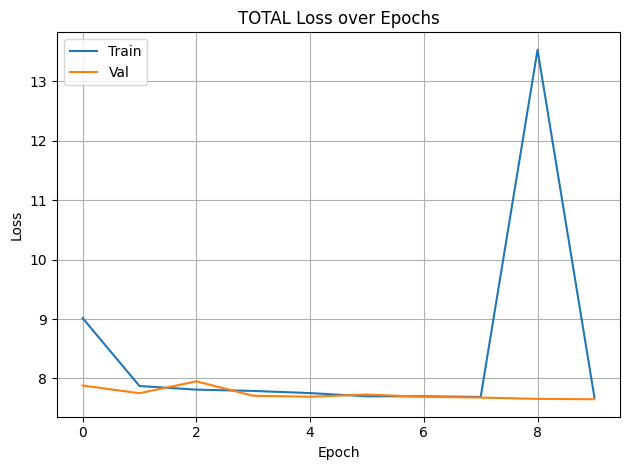

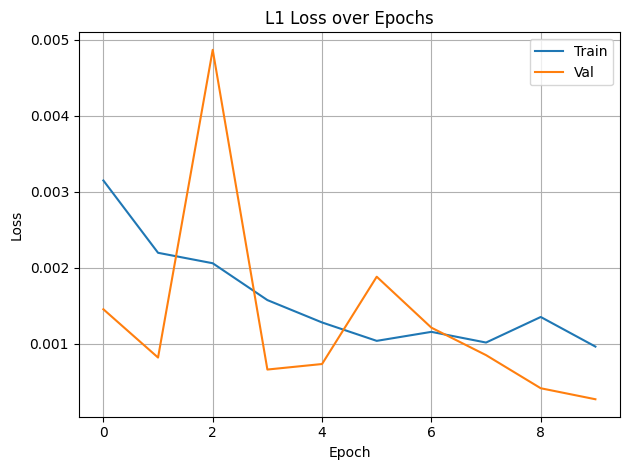

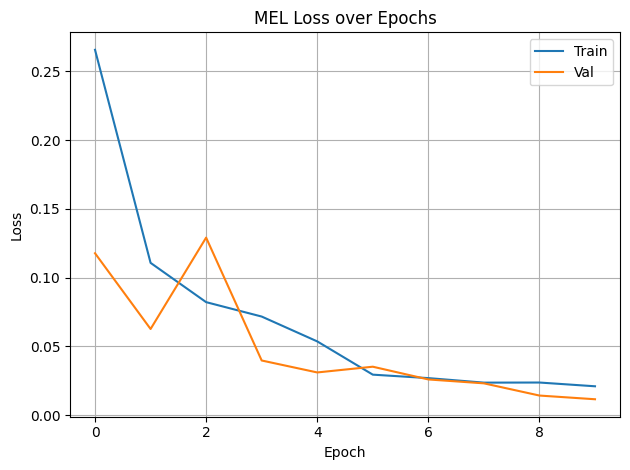

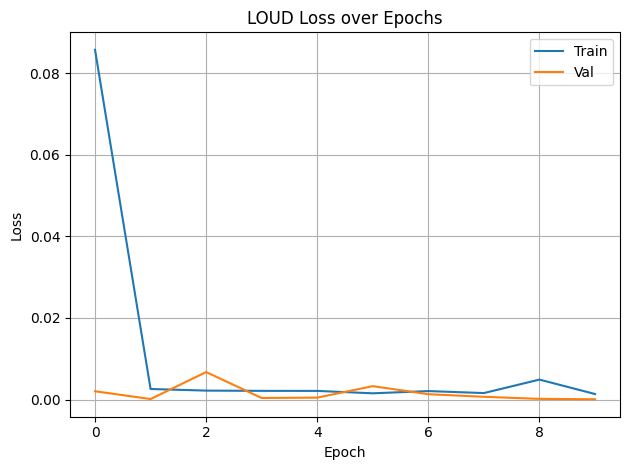

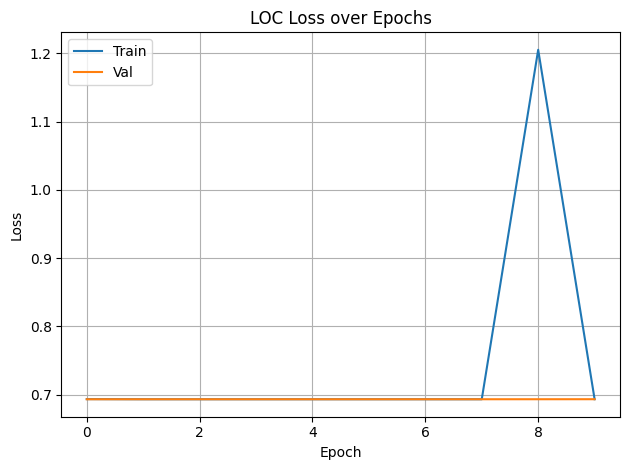

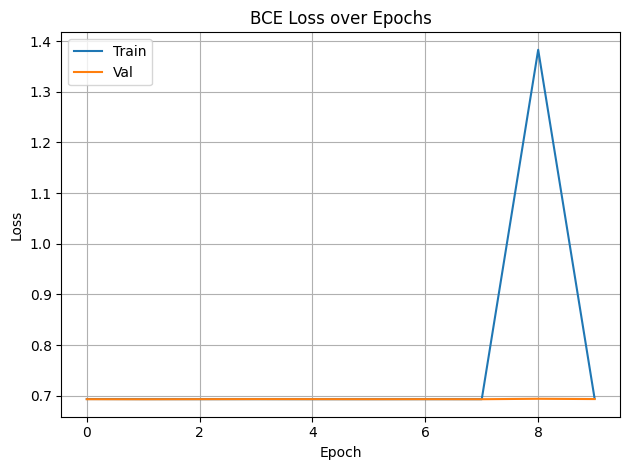

In [34]:
keys = ["total", "l1", "mel", "loud", "loc", "bce"]

for key in keys:
    plt.figure()
    plt.plot([log[key] for log in train_logs], label="Train")
    plt.plot([log[key] for log in val_logs], label="Val")
    plt.title(f"{key.upper()} Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


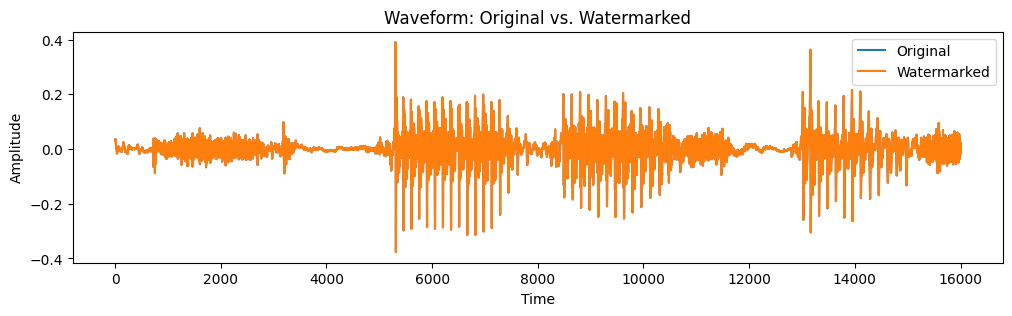

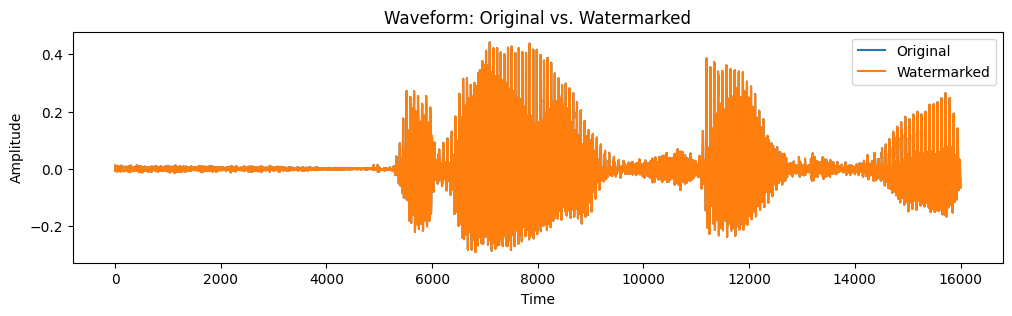

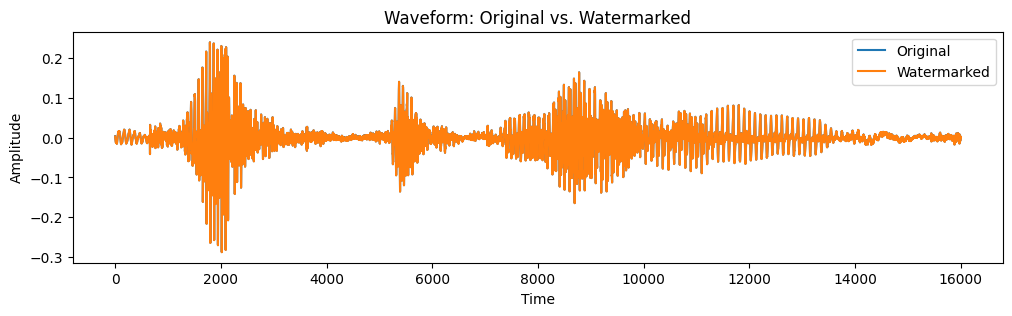

In [37]:

if __name__ == "__main__":
    visualize_delta(generator, val_dataset, device, num_examples=3)

In [ ]:
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key[len(prefix):] if key.startswith(prefix) else key
        new_state_dict[new_key] = value
    model.load_state_dict(new_state_dict, strict=False)


def load_audio(file_path, sample_rate=SAMPLE_RATE):
    waveform, sr = torchaudio.load(file_path)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
    return waveform

def process_audio_file_with_delta(file_path, generator, sample_rate=SAMPLE_RATE, message_bits=MESSAGE_BITS):

    waveform = load_audio(file_path, sample_rate)  
    total_samples = waveform.shape[1]
    seg_len = sample_rate  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    watermarked_segments = []
    delta_segments = []
    
    generator.eval()
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end]  
            seg = seg.to(device)
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            seg = seg.unsqueeze(0)  
            delta_seg = generator(seg, message)  
            watermarked_seg = seg + delta_seg       
            watermarked_segments.append(watermarked_seg.squeeze(0).cpu())
            delta_segments.append(delta_seg.squeeze(0).cpu())
        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            message = torch.randint(0, 2 ** message_bits, (1,), device=device)
            padded_seg = padded_seg.unsqueeze(0)
            delta_seg = generator(padded_seg, message)
            watermarked_seg = padded_seg + delta_seg
            watermarked_seg = watermarked_seg.squeeze(0).cpu()[:, :remainder]
            delta_seg = delta_seg.squeeze(0).cpu()[:, :remainder]
            watermarked_segments.append(watermarked_seg)
            delta_segments.append(delta_seg)
    
    watermarked_waveform = torch.cat(watermarked_segments, dim=1)  
    delta_waveform = torch.cat(delta_segments, dim=1)              
    return watermarked_waveform, delta_waveform, waveform

def compute_si_snr(s, s_hat, eps=1e-8):
    s = s - s.mean(dim=1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=1) / (torch.sum(e_noise ** 2, dim=1) + eps))
    return si_snr.mean().item()

def run_inference_on_file(file_path, generator, detector):

    watermarked_waveform, delta_waveform, original_waveform = process_audio_file_with_delta(
        file_path, generator, sample_rate=SAMPLE_RATE, message_bits=MESSAGE_BITS
    )
    
    if watermarked_waveform.dim() == 3:
        watermarked_waveform = watermarked_waveform.squeeze(0)
    if watermarked_waveform.dim() == 2:
        input_for_detector = watermarked_waveform.unsqueeze(0)
    else:
        input_for_detector = watermarked_waveform
    input_for_detector = input_for_detector.to(device)
    
    with torch.no_grad():
        logits = detector(input_for_detector)  
        detection_logits = logits[:, 0, :]     
        detection_prob = torch.sigmoid(detection_logits).mean().item()
    
    if delta_waveform.dim() == 3:
        delta_waveform = delta_waveform.squeeze(0)
    watermark_rms = torch.sqrt((delta_waveform ** 2).mean()).item()
    
    si_snr_val = compute_si_snr(original_waveform, watermarked_waveform)
    
    return watermarked_waveform, detection_prob, watermark_rms, si_snr_val

def save_audio(waveform, output_path, sample_rate=SAMPLE_RATE):
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    torchaudio.save(output_path, waveform, sample_rate)

generator = Generator(message_bits=MESSAGE_BITS).to(device)
detector = Detector(message_bits=MESSAGE_BITS).to(device)
generator_state = torch.load("generator_best.pth", map_location=device)  
detector_state = torch.load("detector_best.pth", map_location=device)
load_state_dict_strip_prefix(generator, generator_state, prefix="_orig_mod.")
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")
generator.eval()
detector.eval()

input_file = "file_example_WAV_2MG.wav" 
output_file = "inference_results/your_audio_file_watermarked.wav" 

watermarked, det_prob, rms_val, si_snr_val = run_inference_on_file(input_file, generator, detector)
print(f"Detection Probability: {det_prob:.4f}")
print(f"Watermark RMS: {rms_val:.6f}")
print(f"SI-SNR: {si_snr_val:.2f} dB")

if watermarked.dim() == 3:
    watermarked = watermarked.squeeze(0)

save_audio(watermarked.cpu(), output_file, sample_rate=SAMPLE_RATE)
print(f"Watermarked audio saved to: {output_file}")


/tmp/ipykernel_991/2273396672.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator_state = torch.load("generator_best.pth", map_location=device)
/tmp/ipykernel_99

Detection Probability: 0.5053
Watermark RMS: 0.000267
SI-SNR: 73.27 dB
Watermarked audio saved to: inference_results/your_audio_file_watermarked.wav


In [39]:
input_file = "data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg" 
output_file = "inference_results/why_why_watermarked.wav" 

watermarked, det_prob, rms_val, si_snr_val = run_inference_on_file(input_file, generator, detector)
print(f"Detection Probability: {det_prob:.4f}")
print(f"Watermark RMS: {rms_val:.6f}")
print(f"SI-SNR: {si_snr_val:.2f} dB")

if watermarked.dim() == 3:
    watermarked = watermarked.squeeze(0)

save_audio(watermarked.cpu(), output_file, sample_rate=SAMPLE_RATE)
print(f"Watermarked audio saved to: {output_file}")


Detection Probability: 0.5053
Watermark RMS: 0.000267
SI-SNR: 72.01 dB
Watermarked audio saved to: inference_results/why_why_watermarked.wav


/tmp/ipykernel_991/1063598164.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detector_state = torch.load("detector_best.pth", map_location=device)


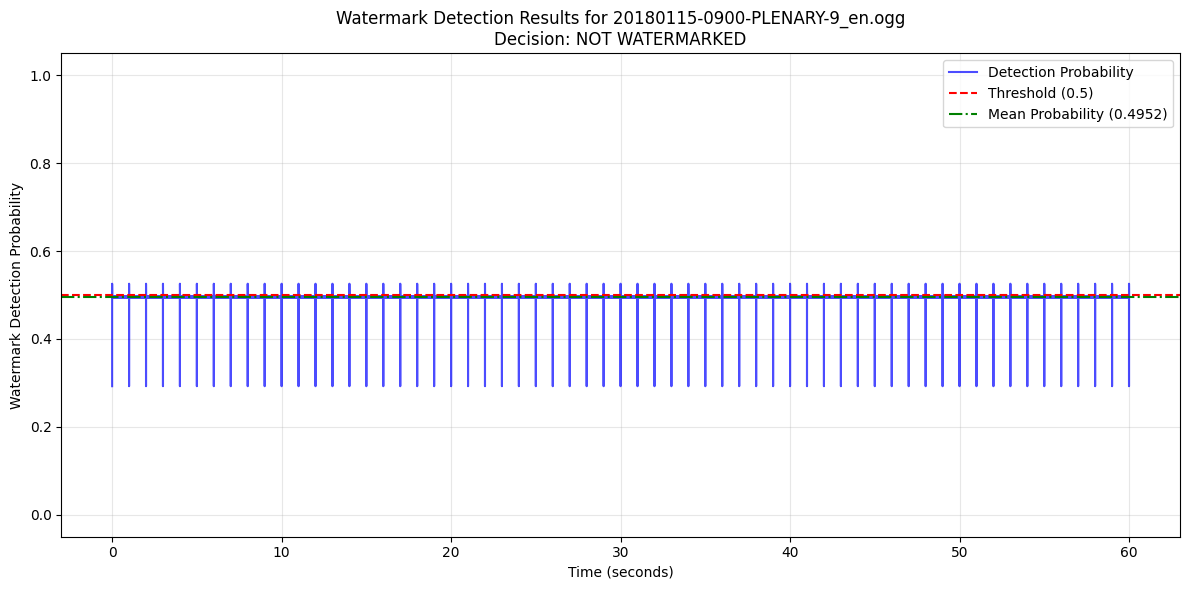

File: data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg
Detection Probability: 0.4952
Decision: NOT WATERMARKED


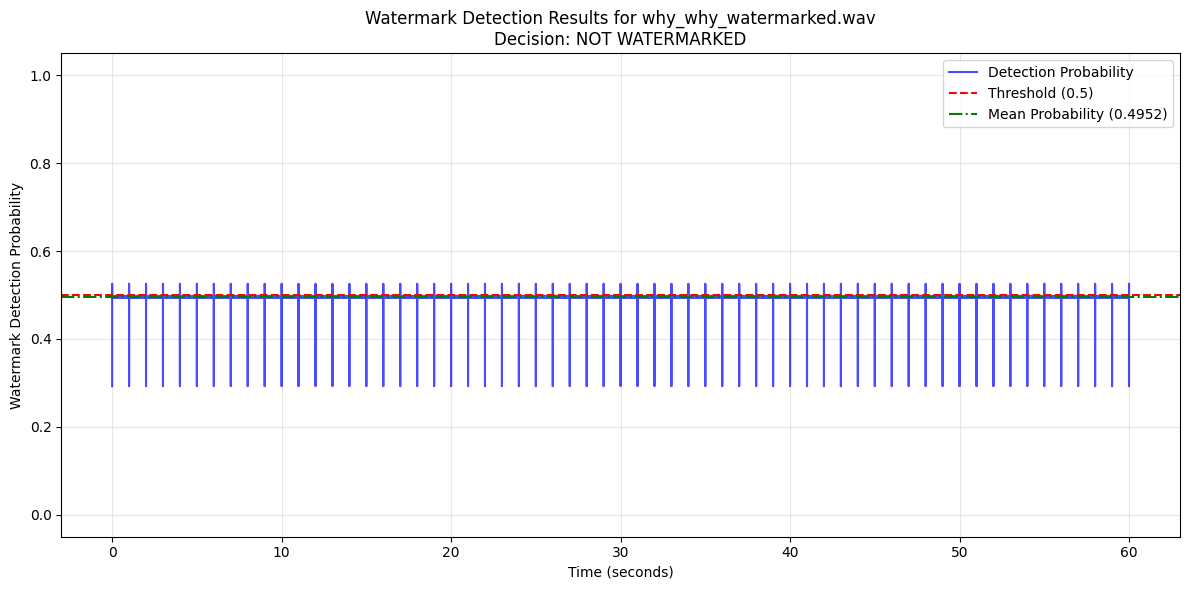


File: inference_results/why_why_watermarked.wav
Detection Probability: 0.4952
Decision: NOT WATERMARKED


In [43]:
def detect_watermark(input_file, detector, detection_threshold=0.5, visualize=True, device="cuda"):
    detector.eval()
    
    waveform, sr = torchaudio.load(input_file)
    if waveform.shape[0] > 1: 
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:  
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)

    total_samples = waveform.shape[1]
    seg_len = SAMPLE_RATE  
    num_full = total_samples // seg_len
    remainder = total_samples % seg_len

    all_probs = []
    all_logits = []
    all_message_logits = []
    
    with torch.no_grad():
        for i in range(num_full):
            start = i * seg_len
            end = start + seg_len
            seg = waveform[:, start:end].to(device)  
            
            seg = seg.unsqueeze(0) 
            
            logits = detector(seg) 
            
            detection_logits = logits[:, 0, :] 
            detection_probs = torch.sigmoid(detection_logits)
            
            if hasattr(detector, 'message_bits') and detector.message_bits > 0:
                message_logits = logits[:, 1:, :].mean(dim=2)
                all_message_logits.append(message_logits.cpu())
            
            all_logits.append(detection_logits.cpu())
            all_probs.append(detection_probs.cpu())
        
        if remainder > 0:
            seg = waveform[:, num_full * seg_len:]
            padded_seg = F.pad(seg, (0, seg_len - seg.shape[1]))
            padded_seg = padded_seg.to(device)
            padded_seg = padded_seg.unsqueeze(0) 
            
            logits = detector(padded_seg)
            
            detection_logits = logits[:, 0, :remainder]
            detection_probs = torch.sigmoid(detection_logits)
            
            if hasattr(detector, 'message_bits') and detector.message_bits > 0:
                message_logits = logits[:, 1:, :remainder].mean(dim=2)
                all_message_logits.append(message_logits.cpu())
            
            all_logits.append(detection_logits.cpu())
            all_probs.append(detection_probs.cpu())
    
    all_probs_cat = torch.cat([p.flatten() for p in all_probs])
    mean_prob = all_probs_cat.mean().item()
    
    is_watermarked = mean_prob > detection_threshold
    temporal_probs = torch.cat(all_probs, dim=1).flatten().numpy()
    
    result = {
        "mean_probability": mean_prob,
        "is_watermarked": is_watermarked,
        "temporal_probs": temporal_probs,
        "decision": "WATERMARKED" if is_watermarked else "NOT WATERMARKED"
    }
    
    if hasattr(detector, 'message_bits') and detector.message_bits > 0 and all_message_logits:
        message_logits_mean = torch.cat(all_message_logits).mean(dim=0)
        predicted_message = (message_logits_mean > 0).int().tolist()
        result["predicted_message"] = predicted_message
        result["message_confidence"] = torch.sigmoid(message_logits_mean).tolist()
    
    if visualize:
        filename = os.path.basename(input_file)
        
        plt.figure(figsize=(12, 6))
        
        time_axis = np.linspace(0, len(temporal_probs) / SAMPLE_RATE, len(temporal_probs))
        plt.plot(time_axis, temporal_probs, label="Detection Probability", color="blue", alpha=0.7)
        plt.axhline(y=detection_threshold, color="red", linestyle="--", label=f"Threshold ({detection_threshold})")
        plt.axhline(y=mean_prob, color="green", linestyle="-.", label=f"Mean Probability ({mean_prob:.4f})")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Watermark Detection Probability")
        plt.title(f"Watermark Detection Results for {filename}\nDecision: {result['decision']}")
        plt.ylim(-0.05, 1.05)       
        plt.legend() 
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return result


detector = Detector(message_bits=MESSAGE_BITS).to(device)
detector_state = torch.load("detector_best.pth", map_location=device)
load_state_dict_strip_prefix(detector, detector_state, prefix="_orig_mod.")


watermarked_file = "data/raw_audios/en/2018/20180115-0900-PLENARY-9_en.ogg"
detection_result = detect_watermark(watermarked_file, detector)



print(f"File: {watermarked_file}")
print(f"Detection Probability: {detection_result['mean_probability']:.4f}")
print(f"Decision: {detection_result['decision']}")


original_file = "inference_results/why_why_watermarked.wav" 
detection_result = detect_watermark(original_file, detector)
print(f"\nFile: {original_file}")
print(f"Detection Probability: {detection_result['mean_probability']:.4f}")
print(f"Decision: {detection_result['decision']}")


/tmp/ipykernel_991/3716678757.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device)

Avg Detection Prob (Clean): 0.4952
Avg Detection Prob (Watermarked): 0.4952
Avg SI-SNR: 67.77 dB
Avg Watermark RMS: 0.000267

Classification Report:
              precision    recall  f1-score   support

       Clean       0.50      1.00      0.67     19704
 Watermarked       0.00      0.00      0.00     19704

    accuracy                           0.50     39408
   macro avg       0.25      0.50      0.33     39408
weighted avg       0.25      0.50      0.33     39408



/home/spandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spandan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


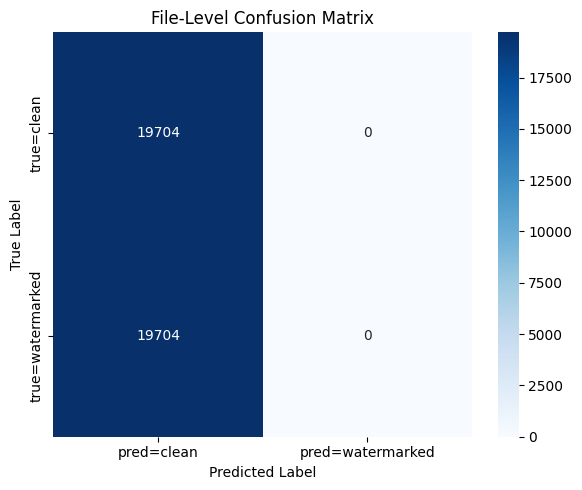

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
def load_state_dict_strip_prefix(model, state_dict, prefix="_orig_mod."):
    new_state_dict = {}
    has_prefix = any(key.startswith(prefix) for key in state_dict.keys())
    if has_prefix:
        for key, val in state_dict.items():
            if key.startswith(prefix):
                new_state_dict[key[len(prefix):]] = val
            else:
                new_state_dict[key] = val
        model.load_state_dict(new_state_dict, strict=False)
    else:
        model.load_state_dict(state_dict)


def compute_si_snr(s, s_hat, eps=1e-8):
    s = s.squeeze(0)
    s_hat = s_hat.squeeze(0)
    s = s - s.mean(dim=-1, keepdim=True)
    s_hat = s_hat - s_hat.mean(dim=-1, keepdim=True)
    dot = torch.sum(s * s_hat, dim=-1, keepdim=True)
    norm_s = torch.sum(s ** 2, dim=-1, keepdim=True)
    alpha = dot / (norm_s + eps)
    s_target = alpha * s
    e_noise = s_hat - s_target
    si_snr = 10 * torch.log10(torch.sum(s_target ** 2, dim=-1) / (torch.sum(e_noise ** 2, dim=-1) + eps))
    return si_snr.mean().item()        

def evaluate_unseen_file(filepath, generator, detector, device):
    try:
        waveform, sr = torchaudio.load(filepath)
    except Exception:
        return None, None, None, None

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(waveform)
    waveform = waveform.to(device)

    clean_probs, wm_probs = [], []
    si_snr_list, rms_list = [], []

    generator.eval(); detector.eval()
    with torch.no_grad():
        for i in range(0, waveform.shape[1], AUDIO_LEN):
            seg = waveform[:, i:i + AUDIO_LEN]
            if seg.shape[1] < AUDIO_LEN:
                seg = F.pad(seg, (0, AUDIO_LEN - seg.shape[1]))
            seg = seg.unsqueeze(0) 
            message = torch.randint(0, 2 ** MESSAGE_BITS, (1,), device=device)
            delta = generator(seg, message)
            seg_w = seg + delta
            logits_clean = detector(seg)[:, 0, :]
            logits_wm    = detector(seg_w)[:, 0, :]
            prob_clean = torch.sigmoid(logits_clean).mean().item()
            prob_wm    = torch.sigmoid(logits_wm).mean().item()
            clean_probs.append(prob_clean)
            wm_probs.append(prob_wm)
            rms_val = torch.sqrt((delta ** 2).mean()).item()
            rms_list.append(rms_val)
            si_val = compute_si_snr(seg, seg_w)
            si_snr_list.append(si_val)

    return (np.mean(clean_probs), np.mean(wm_probs), np.mean(si_snr_list), np.mean(rms_list))

if __name__ == "__main__":
    set_seed(42)

    UNSEEN_DATA_DIR   = "data/test_5_hours"
    GENERATOR_WEIGHTS = "generator_best.pth"
    DETECTOR_WEIGHTS  = "detector_best.pth"
    AUDIO_EXTENSIONS  = ['.wav', '.mp3', '.flac', '.ogg']
    generator = Generator(message_bits=MESSAGE_BITS).to(device)
    detector  = Detector(message_bits=MESSAGE_BITS).to(device)
    load_state_dict_strip_prefix(generator, torch.load(GENERATOR_WEIGHTS, map_location=device))
    load_state_dict_strip_prefix(detector,  torch.load(DETECTOR_WEIGHTS,  map_location=device))

    # collect files
    all_files = []
    for ext in AUDIO_EXTENSIONS:
        all_files += glob.glob(os.path.join(UNSEEN_DATA_DIR, '**', f'*{ext}'), recursive=True)

    # evaluate
    all_clean, all_wm, all_si, all_rms = [], [], [], []
    for f in tqdm(all_files, desc="Evaluating Files"):
        c, w, si, rms = evaluate_unseen_file(f, generator, detector, device)
        if c is not None:
            all_clean.append(c); all_wm.append(w)
            all_si.append(si); all_rms.append(rms)

    overall_clean = np.mean(all_clean)
    overall_wm    = np.mean(all_wm)
    overall_si    = np.mean(all_si)
    overall_rms   = np.mean(all_rms)

    print(f"Avg Detection Prob (Clean): {overall_clean:.4f}")
    print(f"Avg Detection Prob (Watermarked): {overall_wm:.4f}")
    print(f"Avg SI-SNR: {overall_si:.2f} dB")
    print(f"Avg Watermark RMS: {overall_rms:.6f}")
    thresh = 0.5
    y_true = [0]*len(all_clean) + [1]*len(all_wm)
    y_pred = [1 if p>=thresh else 0 for p in all_clean] + [1 if p>=thresh else 0 for p in all_wm]

    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["Clean", "Watermarked"]))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['pred=clean','pred=watermarked'],
                yticklabels=['true=clean','true=watermarked'])
    plt.title('File-Level Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()